# Prediction of R5, X4, and R5X4 HIV-1 Coreceptor Usage

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import entropy
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
import xgboost as xgb
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.pipeline import Pipeline
import os


sns.set_palette("mako")
sns.set_style("darkgrid")
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)


for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/r5-x4-and-r5x4-hiv-1-coreceptor-usage/R5_X4_R5X4.csv


In [2]:
dataset = pd.read_csv("/kaggle/input/r5-x4-and-r5x4-hiv-1-coreceptor-usage/R5_X4_R5X4.csv")
dataset.head(5)

,Sequence,Tropisms,Volume (A3),Mass (daltons),HP Scale,Surface Area,alpha helix,B-strand,Turn,Number of amino acids,Molecular weight,Theoretical pI,Total number of negatively charged residues (Asp + Glu),Total number of positively charged residues (Arg + Lys),Carbon,Hydrogen,Nitrogen,Oxygen,Sulfur,Total number of atoms,Aliphatic index,Grand average of hydropathicity (GRAVY)
0,AB014795,R5X4,11560.0,12186.35,-45.6,77.15,105.63,108.43,98.36,107.0,12204.05,9.86,9.0,16.0,538.0,886.0,160.0,159.0,2.0,1745.0,99.16,-0.426
1,AF062012,R5,12185.0,13009.17,-40.4,85.94,112.18,116.82,113.79,119.0,13026.81,8.67,10.0,13.0,562.0,916.0,164.0,179.0,6.0,1827.0,86.81,-0.339
2,U08716,R5,9730.0,10394.07,-49.9,65.63,88.41,91.53,84.19,91.0,10411.77,10.18,6.0,12.0,452.0,732.0,142.0,137.0,2.0,1465.0,86.70,-0.548
3,AB014785,X4,11632.0,12259.50,-54.1,76.76,105.92,107.97,98.00,107.0,12277.21,10.09,8.0,17.0,541.0,893.0,161.0,158.0,3.0,1756.0,92.80,-0.506
4,AF062029,R5X4,16869.0,17912.05,-46.2,117.81,153.97,159.47,154.77,163.0,17929.58,8.92,13.0,18.0,791.0,1275.0,221.0,239.0,7.0,2533.0,89.08,-0.283


## Data Exploration

In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127 entries, 0 to 126
Data columns (total 22 columns):
 #   Column                                                   Non-Null Count  Dtype  
---  ------                                                   --------------  -----  
 0   Sequence                                                 127 non-null    object 
 1   Tropisms                                                 127 non-null    object 
 2   Volume (A3)                                              127 non-null    float64
 3   Mass (daltons)                                           127 non-null    float64
 4   HP Scale                                                 127 non-null    float64
 5   Surface Area                                             127 non-null    float64
 6   alpha helix                                              127 non-null    float64
 7   B-strand                                                 127 non-null    float64
 8   Turn                          

In [4]:
# Rename Columns
cols = {
    'Volume (A3)':'Volume_A3', 
    'Mass (daltons)':'Mass_Daltons', 
    'HP Scale':'HP_Scale',
    'Surface Area':'Surface_Area', 
    'alpha helix':'Alpha_Helix', 
    'B-strand':'B-Strand',
    'Number of amino acids':'Number_Amino_Acids', 
    'Molecular weight':'Molecular_Weight', 
    'Theoretical pI':'Theoretical_pI',
    'Total number of negatively charged residues (Asp + Glu)':'Total_Negatively_Charged_Residues',
    'Total number of positively charged residues (Arg + Lys)':'Total_Positively_Charged_Residues',
    'Total number of atoms':'Total_Number_Atoms',
    'Aliphatic index':'Aliphatic_Index', 
    'Grand average of hydropathicity (GRAVY)':'Grand_Average_Hydropathicity'
}
dataset.rename(columns= cols, inplace= True)

In [5]:
dataset.describe()

,Volume_A3,Mass_Daltons,HP_Scale,Surface_Area,Alpha_Helix,B-Strand,Turn,Number_Amino_Acids,Molecular_Weight,Theoretical_pI,Total_Negatively_Charged_Residues,Total_Positively_Charged_Residues,Carbon,Hydrogen,Nitrogen,Oxygen,Sulfur,Total_Number_Atoms,Aliphatic_Index,Grand_Average_Hydropathicity
count,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000
mean,36783.157480,39197.960945,-129.391339,251.560315,347.698740,339.406929,321.467165,347.755906,39214.900000,9.248740,33.149606,42.196850,1735.228346,2762.535433,494.850394,509.992126,15.527559,5518.133858,84.896299,-0.442756
std,32931.632413,35066.089755,106.154385,225.712370,313.074169,306.587918,282.332116,309.881178,35065.136402,0.810046,31.270220,35.109814,1566.498746,2469.356830,434.289953,451.944608,14.660619,4935.836293,12.610593,0.220103
min,1880.000000,1969.370000,-460.900000,12.410000,17.390000,19.230000,11.680000,16.000000,1987.330000,6.080000,0.000000,0.000000,96.000000,143.000000,23.000000,23.000000,0.000000,285.000000,33.610000,-1.262000
25%,10320.500000,10859.875000,-198.800000,69.985000,94.460000,97.540000,91.305000,98.000000,10877.610000,8.840000,8.000000,14.000000,482.000000,791.000000,149.500000,142.500000,3.000000,1555.500000,76.025000,-0.593000
50%,16292.000000,17376.360000,-66.600000,113.820000,145.080000,153.760000,152.510000,158.000000,17393.910000,9.160000,13.000000,18.000000,765.000000,1226.000000,220.000000,229.000000,7.000000,2447.000000,86.040000,-0.460000
75%,52862.500000,56571.185000,-48.250000,358.415000,514.085000,463.765000,478.955000,505.000000,56587.605000,9.605000,55.000000,69.000000,2469.000000,3963.000000,722.000000,748.500000,28.500000,7929.000000,92.570000,-0.268500
max,107117.000000,113591.270000,15.500000,718.410000,1019.070000,970.430000,930.350000,1003.000000,113606.460000,12.480000,122.000000,134.000000,5142.000000,8092.000000,1384.000000,1477.000000,42.000000,16116.000000,140.000000,0.662000


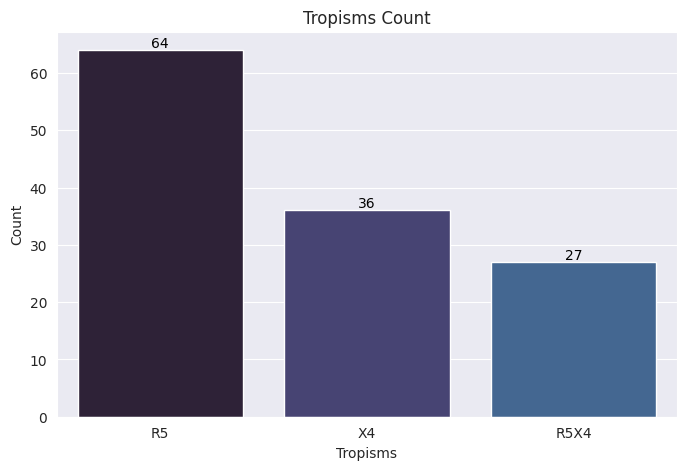

In [6]:
tropisms_count = dataset["Tropisms"].value_counts().reset_index()

plt.figure(figsize= (8,5))
sns.barplot(x= tropisms_count["Tropisms"], y= tropisms_count["count"])

plt.title("Tropisms Count")
plt.xlabel("Tropisms")
plt.ylabel("Count")

for i,value in enumerate(tropisms_count["count"]):
    plt.text(x= i, y= value, s= f"{value}", ha= "center", va= "bottom", color= "black")
plt.show()

### Calculate MI score to perform feature selection

In [7]:
def MI(x, y, bins= 50):
    hist, _, _ = np.histogram2d(x, y, bins= bins)
    
    marginals = [np.sum(hist, axis= i) for i in range(2)]
    
    # Get the entropy
    Px = entropy(marginals[0])
    Py = entropy(marginals[1])
    Pxy = entropy(hist.flatten())
    
    mi = Px + Py - Pxy
    
    return mi

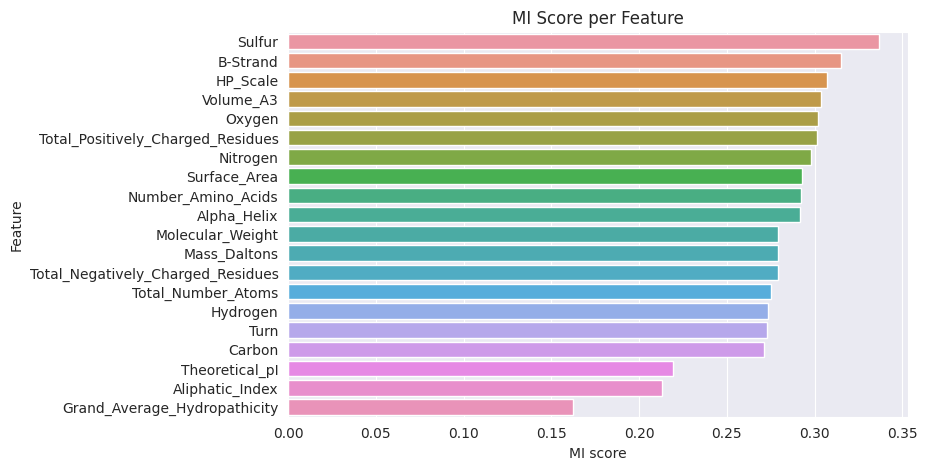

In [8]:
MI_Score = {
    'Variables': [],
    'MI': []
}
for column in dataset.drop(["Sequence", "Tropisms"], axis= 1).columns:
    MI_Score["Variables"].append(column)
    MI_Score["MI"].append(MI(dataset[column].values, pd.Categorical(dataset["Tropisms"]).codes, bins= 50))

MI_df = pd.DataFrame(MI_Score).set_index("Variables").sort_values(by= "MI", ascending= False)

# MI Score BarPlot
plt.figure(figsize= (8, 5))
sns.barplot(y= MI_df.index, x= MI_df["MI"])

plt.title("MI Score per Feature")
plt.xlabel("MI score")
plt.ylabel("Feature")
plt.show()

### Visualize Correlation between Features

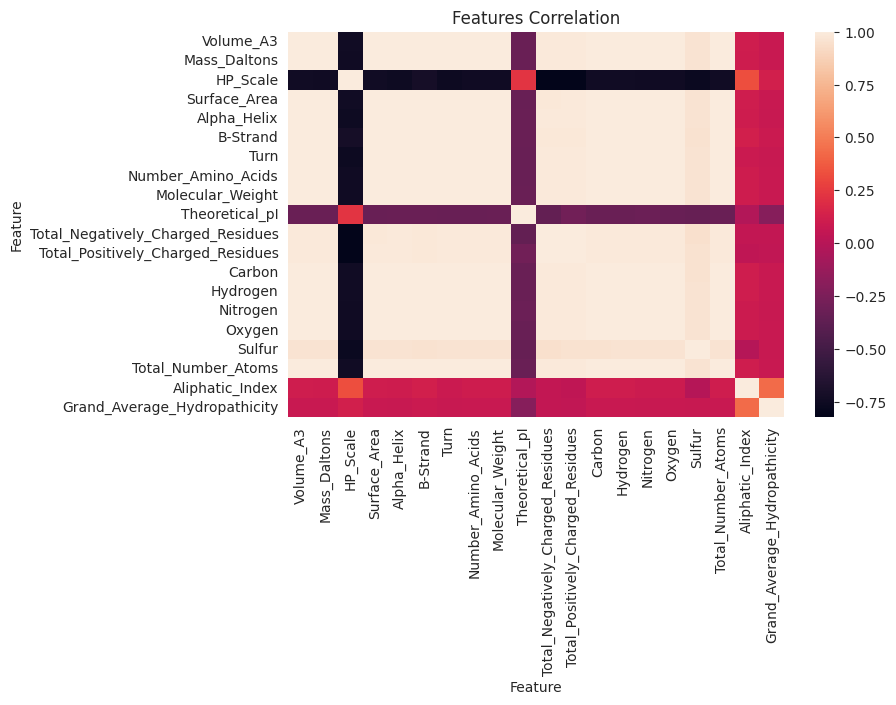

In [9]:
# Heatmap
plt.figure(figsize= (8, 5))
sns.heatmap(dataset.drop(["Sequence", "Tropisms"], axis= 1).corr(), )

plt.title("Features Correlation")
plt.xlabel("Feature")
plt.ylabel("Feature")
plt.show()

### Droping less informative features
* Grand_Average_Hydropathicity
* Aliphatic_Index
* Theoretical_pI

In [10]:
dataset.drop(['Grand_Average_Hydropathicity', 'Aliphatic_Index', 'Theoretical_pI'], axis= 1, inplace= True)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127 entries, 0 to 126
Data columns (total 19 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Sequence                           127 non-null    object 
 1   Tropisms                           127 non-null    object 
 2   Volume_A3                          127 non-null    float64
 3   Mass_Daltons                       127 non-null    float64
 4   HP_Scale                           127 non-null    float64
 5   Surface_Area                       127 non-null    float64
 6   Alpha_Helix                        127 non-null    float64
 7   B-Strand                           127 non-null    float64
 8   Turn                               127 non-null    float64
 9   Number_Amino_Acids                 127 non-null    float64
 10  Molecular_Weight                   127 non-null    float64
 11  Total_Negatively_Charged_Residues  127 non-null    float64

## Trying to Predict the R5X4 Coreceptor Usage using XGBoost
* Data Preprocessing
* Training the Model:
    * Dimensionality reduction performing PCA.
    * Predict with the XGBoost model.
    * Apply Grid-Search to tune PCA and XGBoost hyperparameters.
* Testing the Model
    * ROC curve and AUC score.
    * Validation score.
* Predict the class for the R5X4 coreceptor.

### Data Preprocessing 

In [11]:
# As we know, there are 64 samples for R5, 36 for X4 and 27 for R5X4 
# to balance the data we can take only 36 samples for R5 and X4.
samples = dataset[dataset.Tropisms != "R5X4"].groupby("Tropisms").head(62) #36

# R5 and X4 Coreceptor data.
Xs = samples.drop(["Sequence", "Tropisms"], axis= 1).values
y = pd.Categorical(samples.Tropisms).codes

# We wiil use the rest of R5 data as validation.
validation = dataset[~dataset.isin(samples)][dataset.Tropisms != "R5X4"].dropna()

# Use the R5X4 Coreceptor data to predict.
testing = dataset[~dataset.isin(samples)][dataset.Tropisms == "R5X4"]

# Standardize data
stc = StandardScaler()

x_train = stc.fit_transform(Xs)
y_train = y

x_val = stc.transform(validation.drop(["Sequence", "Tropisms"], axis= 1).values)
y_val = pd.Categorical(validation.Tropisms).codes

test = stc.transform(testing.drop(["Sequence", "Tropisms"], axis= 1).values)

### Training the Model

In [12]:
pipeline = Pipeline(
    [
        ("PCA", PCA()),
        ("Model", xgb.XGBClassifier())
    ])

params= {
    "PCA__n_components": range(1,18),
    "Model__n_estimators": [100, 300, 500],
    "Model__eta": [0.1, 0.01, 0.001]
}

grid_clf = GridSearchCV(pipeline, params, cv= 5, n_jobs= -1)
grid_clf.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('PCA', PCA()),
                                       ('Model',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_types=None,
                                                      gamma=None,
                                                      grow_policy=None,
                                                      importance_type=None,
                                                      interacti...
                                                      max_cat_to_onehot=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=None, ...))]),
             n_jobs=-1,
             param_grid={'Model__eta': [0.1, 0.01, 0.001],
                         'Model__n_estimators': [100, 300, 500],
                         'PCA__n_components': range(1, 18)})

### Testing the Model

#### Training Data

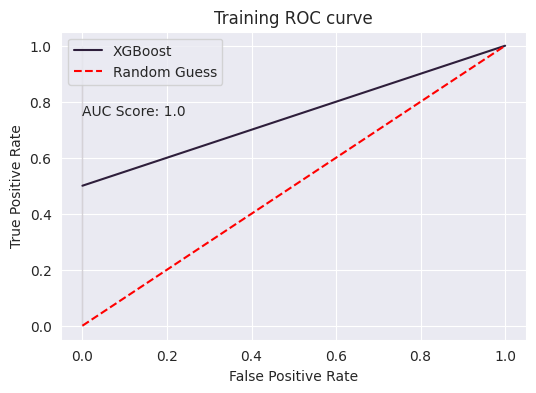

In [13]:
# Training ROC curve and AUC score
train_pred = grid_clf.predict(x_train)
fpr, tpr, _ = roc_curve(y_train, train_pred)
auc_score = auc(fpr, tpr)

plt.figure(figsize=(6, 4))

sns.lineplot(x= fpr, y= tpr, label= "XGBoost") # XGBoost Model
sns.lineplot(x= [0,1], y= [0,1], color= "red", label= "Random Guess", linestyle='--') # Random Guess
plt.title("Training ROC curve")


plt.text(x= 0, y=0.75, s= f"AUC Score: {auc_score}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

In [14]:
# Training Confusion Matrix
confusion_matrix(train_pred, y_train)

array([[62,  0],
       [ 0, 36]])

#### Validation Data

In [15]:
# Validation Score
val_score = grid_clf.score(x_val, y_val)
print(f"Validation Score: {val_score}")

Validation Score: 1.0


### Predict the class for the R5X4 coreceptor.

In [16]:
r5x4 = np.array(["X4" if cor else "R5" for cor in grid_clf.predict(test)])
coreceptors = testing[["Sequence", "Tropisms"]].copy()
coreceptors["Coreceptor Predicted"] = r5x4
coreceptors

,Sequence,Tropisms,Coreceptor Predicted
0,AB014795,R5X4,X4
4,AF062029,R5X4,X4
7,AF062031,R5X4,X4
11,AF062033,R5X4,X4
14,AF107771,R5X4,R5
18,U08680,R5X4,R5
21,U08682,R5X4,R5
25,U08444,R5X4,R5
29,U08445,R5X4,R5
33,AF355674,R5X4,X4
